In [1]:
import torch
from torch import optim, nn
import h5py

from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset, DataLoader

In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path):
        self.h5file = h5py.File(path, 'r')
        self.images = list(self.h5file.keys())

    def __len__(self):
        return len(self.images) * 7

    def __getitem__(self, idx):
        filename = self.images[idx // 7]
        image = self.h5file[filename][:, :, [idx % 7]].astype(np.float32)
        image = (image - 10000) / 10000

        return np.moveaxis(image, -1, 0), idx % 7
    
    def __del__(self):
        self.h5file.close()

train_ds = SatelliteDataset("datasets/landsat8.hdf5")
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True)

In [3]:
a, b = next(iter(train_dl))

a.shape, b.shape

(torch.Size([512, 1, 85, 85]), torch.Size([512]))

In [4]:
#https://www.researchgate.net/figure/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the_fig2_348947034
class Transformer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.mha = nn.MultiheadAttention(emb_dim, num_heads=4, batch_first=True) ##2?

        self.ln2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
            #nn.Dropout(0.1),
        )

    def forward(self, x):
        x_ln = self.ln1(x)
        att, _ = self.mha(x_ln, x_ln, x_ln)
        
        att = self.ln2(att + x)
        return self.mlp(att) + att

In [5]:
#https://medium.com/@14prakash/masked-autoencoders-9e0f7a4a2585
class MyMAE(nn.Module):
    def __init__(self, in_c, img_size, patch_size, emb_dim):
        super().__init__()
        assert img_size % patch_size == 0

        self.emb_dim = emb_dim
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (self.img_size // self.patch_size) ** 2

        self.patch_embedding = nn.Conv2d(1, self.emb_dim, 
                                         kernel_size=patch_size, 
                                         stride=patch_size,
                                         bias=False)

        self.channel_embedding = nn.Parameter(torch.zeros(in_c, emb_dim))
        torch.nn.init.normal_(self.channel_embedding, std=.02)

        self.pos_embedding = nn.Parameter(torch.zeros(self.num_patches, self.emb_dim))
        torch.nn.init.normal_(self.pos_embedding, std=.02)
        
        self.encoder = nn.Sequential(*[Transformer(self.emb_dim) for _ in range(10)])
        self.decoder = nn.Sequential(*[Transformer(self.emb_dim) for _ in range(2)])

        self.decoder_emb_dim = self.emb_dim
        self.decoder_emb = nn.Linear(self.emb_dim, self.decoder_emb_dim, bias=False)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.decoder_emb_dim))
        torch.nn.init.normal_(self.mask_token, std=.02)

        self.decoder_pos_emb = nn.Parameter(torch.zeros(self.num_patches, self.decoder_emb_dim))
        torch.nn.init.normal_(self.decoder_pos_emb, std=.02)

        self.img_recov = nn.Linear(self.decoder_emb_dim, 1 * (self.patch_size ** 2), bias=True)
        

    def forward(self, x, c):
        bs, _, _, _ = x.shape
        device = x.device

        patches = self.patch_embedding(x)
        patches = patches.flatten(2, 3).transpose(1, 2)

        masked_entries = int(0.75 * self.num_patches)
        mask = torch.randperm(self.num_patches, device=device) #img size independent?
        mask = mask[:-masked_entries]

        tokens = patches[:, mask, :] + self.pos_embedding[None, mask, :] + self.channel_embedding[c, None, :]
        features = self.encoder(tokens)

        ###### bottleneck

        tokens = self.mask_token.repeat(bs, self.num_patches, 1)
        tokens[:, mask, :] = self.decoder_emb(features)

        tokens = tokens + self.decoder_pos_emb[None, :, :]
        features = self.decoder(tokens)

        image = self.img_recov(features)

        image = image.transpose(1,2)
        image = nn.functional.fold(image, 
                                   kernel_size=self.patch_size, 
                                   output_size=self.img_size, 
                                   stride=self.patch_size)
        
        return image

In [6]:
device = "cuda"

model = MyMAE(7, 85, 5, 64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.2e-4)
mse_loss = nn.MSELoss()

for epoch in range(20):
    mean_loss = 0
    for i, data in enumerate(tqdm(train_dl)):
        img, c = data
        img, c = img.to(device), c.to(device)

        reconstruction = model(img, c)
        loss = mse_loss(reconstruction, img)
        mean_loss += loss.item()

        if i % 3 == 0:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    mean_loss /= len(train_dl)
    print(f"Epoch {epoch} Loss {mean_loss:.4f}")

#0.33

/home/alunos/.pyenv/versions/3.10.12/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3189/3189 [06:13<00:00,  8.53it/s]


Epoch 0 Loss 0.7060


100%|██████████| 3189/3189 [06:13<00:00,  8.53it/s]


Epoch 1 Loss 0.6551


100%|██████████| 3189/3189 [06:13<00:00,  8.53it/s]


Epoch 2 Loss 0.6079


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 3 Loss 0.4676


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 4 Loss 0.4387


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 5 Loss 0.4255


100%|██████████| 3189/3189 [06:12<00:00,  8.55it/s]


Epoch 6 Loss 0.4069


100%|██████████| 3189/3189 [06:13<00:00,  8.55it/s]


Epoch 7 Loss 0.3885


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 8 Loss 0.3772


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 9 Loss 0.3685


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 10 Loss 0.3624


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 11 Loss 0.3567


100%|██████████| 3189/3189 [06:13<00:00,  8.55it/s]


Epoch 12 Loss 0.3527


100%|██████████| 3189/3189 [06:13<00:00,  8.55it/s]


Epoch 13 Loss 0.3492


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 14 Loss 0.3452


100%|██████████| 3189/3189 [06:13<00:00,  8.53it/s]


Epoch 15 Loss 0.3424


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 16 Loss 0.3390


100%|██████████| 3189/3189 [06:13<00:00,  8.55it/s]


Epoch 17 Loss 0.3362


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]


Epoch 18 Loss 0.3342


100%|██████████| 3189/3189 [06:13<00:00,  8.54it/s]

Epoch 19 Loss 0.3317


In [13]:
torch.save(model.state_dict(), "model.pth")

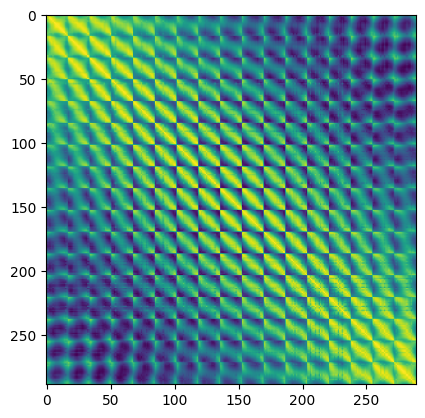

In [14]:
sd = torch.load("model.pth")

import matplotlib.pyplot as plt
plt.imshow(torch.corrcoef(sd['decoder_pos_emb']).cpu().detach().numpy());

In [22]:
print(sd.keys())
A = sd['channel_embedding']

A.std()

odict_keys(['channel_embedding', 'pos_embedding', 'mask_token', 'decoder_pos_emb', 'patch_embedding.weight', 'encoder.0.ln1.weight', 'encoder.0.ln1.bias', 'encoder.0.mha.in_proj_weight', 'encoder.0.mha.in_proj_bias', 'encoder.0.mha.out_proj.weight', 'encoder.0.mha.out_proj.bias', 'encoder.0.ln2.weight', 'encoder.0.ln2.bias', 'encoder.0.mlp.0.weight', 'encoder.0.mlp.0.bias', 'encoder.0.mlp.2.weight', 'encoder.0.mlp.2.bias', 'encoder.1.ln1.weight', 'encoder.1.ln1.bias', 'encoder.1.mha.in_proj_weight', 'encoder.1.mha.in_proj_bias', 'encoder.1.mha.out_proj.weight', 'encoder.1.mha.out_proj.bias', 'encoder.1.ln2.weight', 'encoder.1.ln2.bias', 'encoder.1.mlp.0.weight', 'encoder.1.mlp.0.bias', 'encoder.1.mlp.2.weight', 'encoder.1.mlp.2.bias', 'encoder.2.ln1.weight', 'encoder.2.ln1.bias', 'encoder.2.mha.in_proj_weight', 'encoder.2.mha.in_proj_bias', 'encoder.2.mha.out_proj.weight', 'encoder.2.mha.out_proj.bias', 'encoder.2.ln2.weight', 'encoder.2.ln2.bias', 'encoder.2.mlp.0.weight', 'encoder.2.

tensor(0.0267, device='cuda:0')